In [1]:
import pandas as pd
import scipy
import shap
import numpy as np
import ZCA as zca
import statsmodels.api as sm
import matplotlib as plt

from numpy import mean
from numpy import arange
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.linear_model import ElasticNet
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
all_data = pd.read_csv('/mnt/distvol/states.csv')
all_data.index = all_data.iloc[:,0]
#np.random.seed(seed)
#tf.random.set_seed(seed)

trf = zca.ZCA().fit(all_data.iloc[:,1:])

X = pd.DataFrame(trf.transform(all_data.iloc[:,1:]))
X.index = all_data.index
#from sklearn.preprocessing import StandardScaler

y = pd.DataFrame((all_data.iloc[:,1]-np.mean(all_data.iloc[:,1]))/np.std(all_data.iloc[:,1]))
y.columns=pd.DataFrame(all_data.iloc[:,1]).columns
y.index = all_data.index
#StandardScaler().fit_transform(all_data.iloc[:,1])

#exclude y
trf = zca.ZCA().fit(all_data.iloc[:,2:])

X = pd.DataFrame(trf.transform(all_data.iloc[:,2:]))
X.columns=pd.DataFrame(all_data.iloc[:,2:]).columns
X.index = all_data.index

data = pd.concat([y,X],axis=1)
print(data.columns)
data.index = all_data.index
Path="/mnt/distvol"
filename="data"
data.to_csv("/mnt/distvol/data.csv",index=False)
#data.to_csv(Path(p, filename + '.csv')), index=False)(data, "/mnt/distvol/data.csv")

Index(['Poverty', 'Infant Mort', 'White', 'Crime', 'Doctors', 'Traf Deaths',
       'University', 'Unemployed', 'Income', 'Population'],
      dtype='object')


In [3]:
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [4]:

#backwards step
max_pvalue = 1
New_Names = X.columns
X_b = X
while (max_pvalue > .05):
    
    X_b = X_b[New_Names]
    #X.index = all_data.index
    #labels_true = X.index

    #reg = LinearRegression().fit(X, y)

    #print(reg.score(X, y),reg.coef_,reg.intercept_)

    model = sm.OLS(y,X_b)
    results = model.fit()

    max_pvalue = max(results.pvalues)
    max_pname = (results.pvalues).idxmax(axis=1)
    set_ = X_b.columns.tolist()
    set_.remove(max_pname)
    New_Names = set_

print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                Poverty   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.856
Method:                 Least Squares   F-statistic:                              50.47
Date:                Mon, 03 May 2021   Prob (F-statistic):                    4.00e-18
Time:                        21:49:01   Log-Likelihood:                         -19.332
No. Observations:                  50   AIC:                                      50.66
Df Residuals:                      44   BIC:                                      62.14
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [5]:
# evaluate an elastic net model on the dataset
tsize = .3
train, test = train_test_split(all_data, test_size=tsize, shuffle=True)

std_ = np.std(train.iloc[:,1])
mean_ = np.mean(train.iloc[:,1])
y_train = pd.DataFrame((train.iloc[:,1]-mean_)/std_)
y_train.columns=pd.DataFrame(train.iloc[:,1]).columns
y_train.index = train.index

#StandardScaler().fit_transform(all_data.iloc[:,1])

#exclude y
trf = zca.ZCA().fit(all_data.iloc[:,2:])

X_train = pd.DataFrame(trf.transform(train.iloc[:,2:]))
X_train.columns=pd.DataFrame(train.iloc[:,2:]).columns
X_train.index = train.index

y_test = pd.DataFrame((test.iloc[:,1]-np.mean(train.iloc[:,1]))/np.std(train.iloc[:,1]))
y_test.columns=pd.DataFrame(test.iloc[:,1]).columns
y_test.index = test.index

X_test = pd.DataFrame(trf.transform(test.iloc[:,2:]))
X_test.columns=pd.DataFrame(test.iloc[:,2:]).columns
X_test.index = test.index


In [6]:

'''
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
'''

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, verbose=0)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

# define model
model = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_)

# fit model
model.fit(X_train, y_train)

# define new data
#row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
# make a prediction
yhat = model.predict(X_test)
# summarize prediction
#print('Predicted: %.3f' % yhat)

alpha: 0.100000
l1_ratio_: 0.990000


In [7]:
coef = pd.DataFrame(model.coef_).set_index(X_train.columns)
a_coef = abs(coef)
a_coef.sort_values(by=[0],ascending=False,inplace=True)
a_coef

,0
Income,0.795949
Crime,0.157371
White,0.055312
Population,0.005813
Infant Mort,0.000000
Doctors,0.000000
Traf Deaths,0.000000
University,0.000000
Unemployed,0.000000


In [8]:
print(model.score(X_train, y_train, sample_weight=None))
print(model.score(X_test, y_test, sample_weight=None))
print(model.score(X, y, sample_weight=None))
print(model.coef_)

0.7837783918531405
0.7045883697178357
0.7828097265676317
[-0.         -0.05531176  0.15737099  0.          0.          0.
  0.         -0.79594916  0.0058126 ]


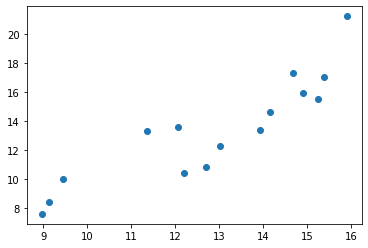

rmse 3.708873324083887
mape Poverty    10.931603
dtype: float64


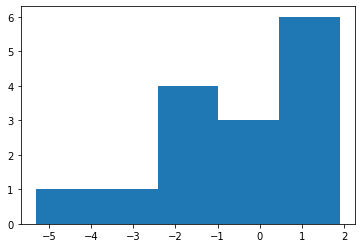

In [9]:
import matplotlib.pyplot as plt
predicted = pd.DataFrame(yhat*std_+mean_)
predicted.index = y_test.index
predicted.columns = y_test.columns
actual = pd.DataFrame(y_test*std_+mean_)
actual.index = y_test.index
plt.scatter(predicted, actual)

plt.show()

plt.hist(predicted-actual, bins='auto')  # arguments are passed to np.histogram

rmse = mean_squared_error(actual, predicted, squared=True)
mape = MAPE(actual, predicted)

print("rmse",rmse)
print("mape",mape)

Index(['Poverty'], dtype='object')


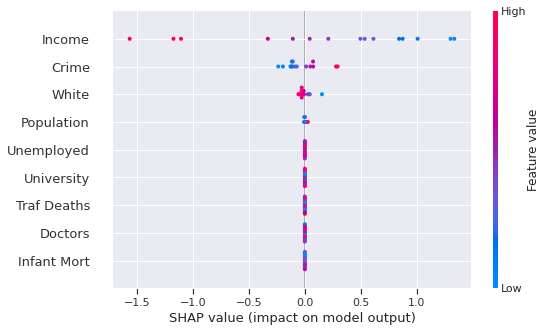

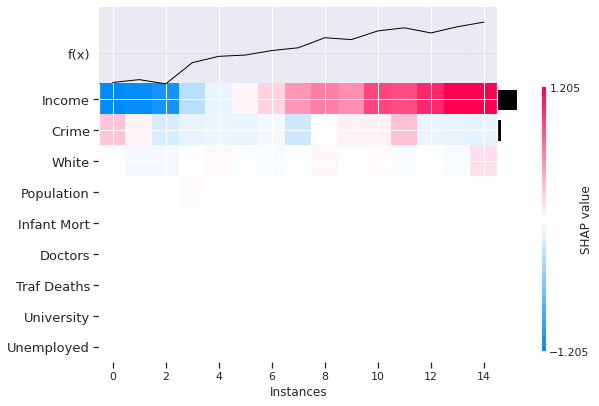

In [156]:
%matplotlib inline
shap.initjs()

# select a set of background examples to take an expectation over
background = np.array(data)
#[np.random.choice(X_train.shape[0],100,replace=False)]

#model = sklearn.linear_model.LinearRegression()
#model.fit(data.iloc[:,1:], data.iloc[:,0])

# explain predictions of the model on four images
e = shap.LinearExplainer(model, X_train)
#explainer = shap.KernelExplainer(model, X_train, link="logit")
print(y_test.columns)
shap_values = e.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
explainer = shap.Explainer(model, X_train)
shap.plots.heatmap(explainer(X_test))

In [11]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

pre_list = feature_importance[feature_importance["feature_importance_vals"]>.025]["col_name"].values.tolist()
pre_list.insert(0,all_data.columns[1])

In [12]:
set_ = data[pre_list]
set_.index = all_data.iloc[:,0]
#set_ = data[["Poverty","Income"]]

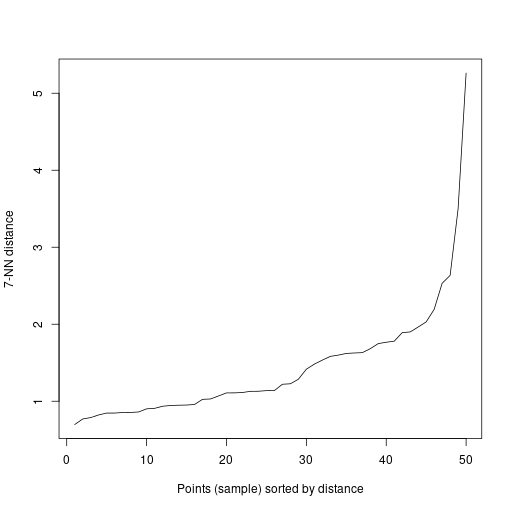

In [13]:

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

k = 7

grdevices = importr('grDevices')

grdevices.png(file="kNNdistplot.png", width=512, height=512)
ro.r('''
eq <- function(values, k_) {
library(dbscan,lib.loc = "/mnt/distvol/R-4.0.5/library")
#data <- read.csv("/mnt/distvol/data.csv")
kNNdistplot(values,k=k_)
}
''')
r_eq = ro.globalenv['eq']
p=ro.conversion.rpy2py((r_eq(ro.conversion.py2rpy(set_),k)))
#p = ro.r('eq(1)')            # OUTPUTS TO FILE
grdevices.dev_off()
from IPython.display import Image
Image("kNNdistplot.png")


In [14]:
from sklearn.cluster import DBSCAN
#import sklearn.utils
#from sklearn.preprocessing import StandardScaler
#X = StandardScaler().fit_transform(all_data.iloc[:,1:])

eps_tries = arange(0.1, 5, 0.1)
clusters = []

for i in range(0,len(eps_tries)):
    
    db = DBSCAN(eps=eps_tries[i], min_samples=3).fit(set_)
    labels = db.labels_
    #print (labels)
    X["Clus_Db"]=labels
    realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
    clusterNum = len(set(labels))
    clusters.append(clusterNum)

max_e = pd.DataFrame(clusters)[0].idxmax(axis=1)

db = DBSCAN(eps=eps_tries[max_e], min_samples=3).fit(set_)
labels = db.labels_
print (labels)
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

[-1 -1  2 -1  0  0 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  3 -1 -1  2  1 -1
  2  1  1 -1 -1 -1 -1 -1 -1  3  1 -1  1  1  0 -1  3 -1  1  1 -1 -1  0 -1
  1  1]


In [15]:
all_data['clusters'] = labels
set_["clusters"]=labels

array([0.84616409, 0.06825231, 0.75061091, 0.94179815, 0.5773916 ,
       0.32354217, 0.11907986, 0.17386413, 0.56389597, 0.75061091,
       0.10595324, 0.48190652, 0.42745723, 0.55032552, 0.33598501,
       0.31129357, 0.94179815, 0.94179815, 0.44098159, 0.05568715,
       0.17386413, 0.71677976, 0.1408547 , 0.99819576, 0.59079699,
       0.76139096, 0.25333235, 0.31129357, 0.03887447, 0.08290053,
       0.93336203, 0.61727695, 0.73957732, 0.40067791, 0.59079699,
       0.86189233, 0.61727695, 0.41401759, 0.36140545, 0.84616409,
       0.4682221 , 0.8292938 , 0.8541707 , 0.1408547 , 0.23184594,
       0.19207817, 0.31129357, 0.92880344, 0.21141463, 0.12605727])

In [16]:
all_data[all_data['clusters']>=-1][set_.columns].groupby('clusters').mean()

,Poverty,Income,Crime,White
clusters,,,,
-1,13.070370,52842.370370,478.481481,76.422222
0,11.925000,57948.250000,357.750000,84.775000
1,12.053846,50461.846154,313.153846,89.761538
2,14.166667,48805.333333,508.000000,84.233333
3,12.266667,46099.333333,143.000000,92.000000


([<matplotlib.lines.Line2D at 0x7fafe78b0340>,
 ['$\\mathdefault{40}$',
  '$\\mathdefault{80}$',
  '$\\mathdefault{120}$',
  '$\\mathdefault{160}$',
  '$\\mathdefault{200}$'])

In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

sns.set(style = "darkgrid")

fig = plt.figure(figsize=[16,16])
ax = fig.add_subplot(111, projection = '3d')

x = set_.iloc[:,1]
y = set_.iloc[:,2]
z = set_.iloc[:,3]

m = np.array([x,y,z])
scatter = ax.scatter(x,y,z, c=set_.iloc[:,0], cmap="RdYlGn", s=(set_['clusters']+2)*40, edgecolors="black")

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

#legend2 = ax.legend(*scatter.legend_elements(prop="sizes", alpha=0.6),loc="upper left", title="clusters")

legend2 = ax.legend(handles, range(0,len(labels)), loc="upper right", title="clusters")
#ax.legend()
ax.add_artist(legend2)
    
states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
for i in range(len(m[0]-1)): #plot each point + it's index as text above 
    ax.scatter(m[0,i],m[1,i],m[2,i], marker=set_.iloc[i]['clusters']+2, s=100, color='k') 
    ax.text(m[0,i],m[1,i],m[2,i],  '%s' % (str(states[i])), size=10, zorder=1,  color='k') 
   
#legend1 = ax.legend(*scatter.legend_elements(num=5),loc="upper left", title="Ranking")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Poverty")
ax.add_artist(legend1)


#kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="$ {x:.2f}",func=lambda s: np.sqrt(s/.3)/3)

#legend2 = ax.legend(*scatter.legend_elements(**kw),loc="lower right", title="Price")

ax.legend()
ax.set_xlabel(set_.columns[1])
ax.set_ylabel(set_.columns[2])
ax.set_zlabel(set_.columns[3])
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


States
Maine           96.4
North Dakota    91.4
South Dakota    88.2
Name: White, dtype: float64

cluster:
-1


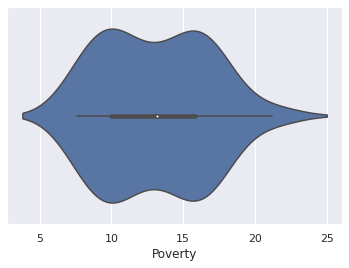

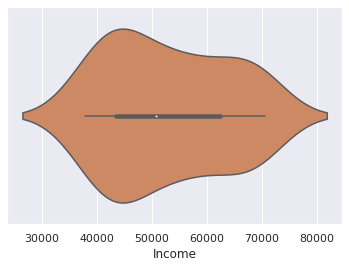

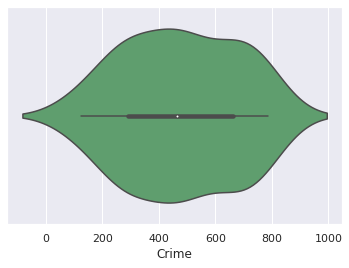

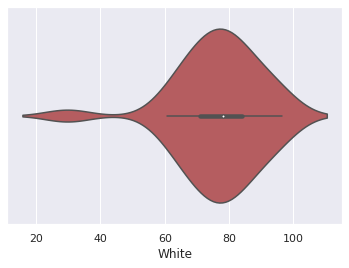

cluster:
0


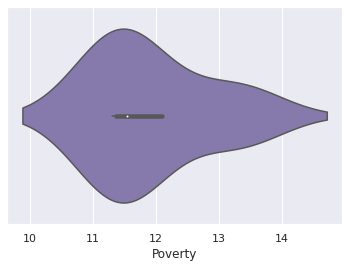

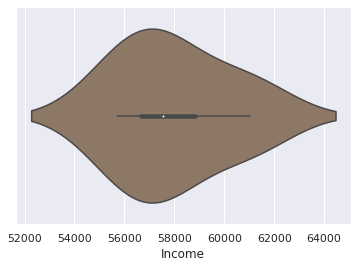

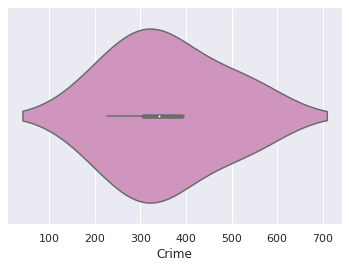

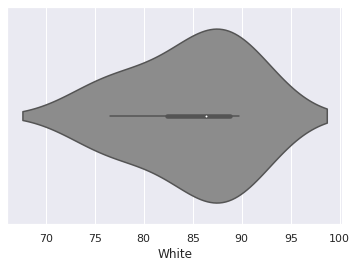

cluster:
1


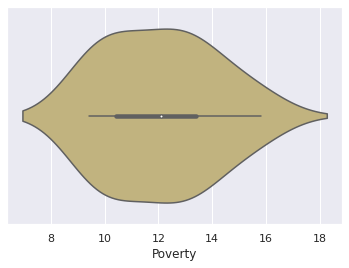

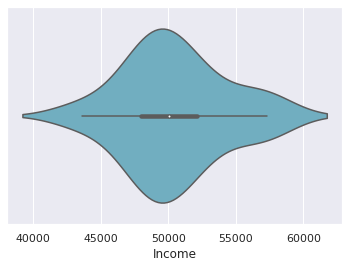

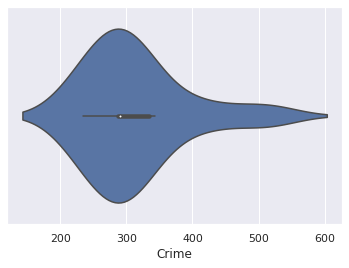

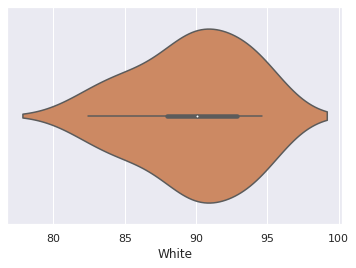

cluster:
2


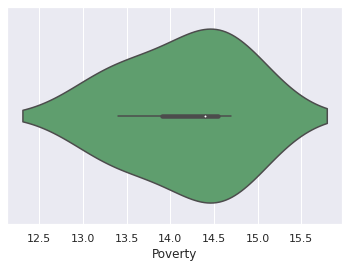

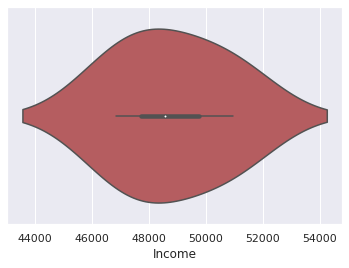

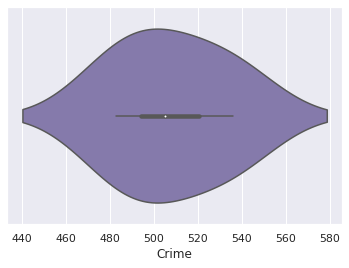

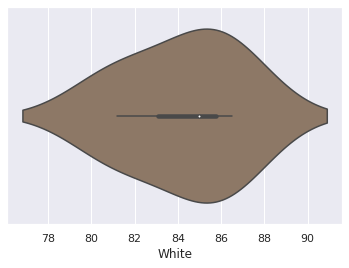

cluster:
3


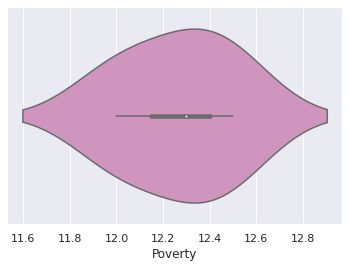

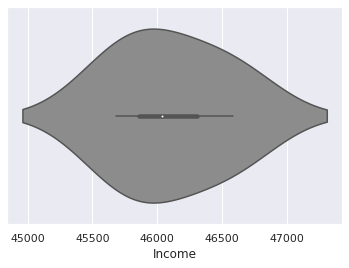

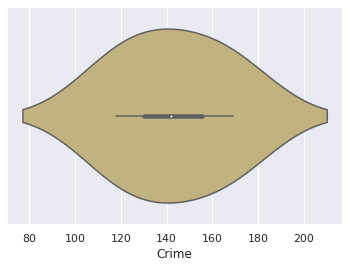

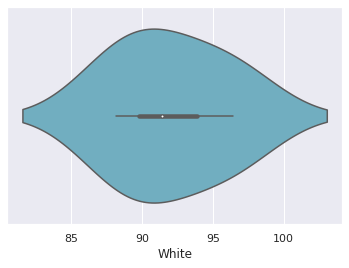

In [32]:
# Violin Plots of Minimum and Maximum Temperature
from itertools import cycle

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

%matplotlib inline 
for i in range(-1,clusterNum-1):
    print("cluster:")
    print(i)
    fig = plt.figure(figsize=(6,4))    
    for j in range(0,len(set_.columns)-1):                
        #plt.subplot(1,2,1)
        sns.violinplot(x=all_data[all_data['clusters']==i][set_.columns[j]],color=next(colors))
        plt.show()
